## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
df = pd.read_csv('E:/PTDLKD/Đồ án/dataset/NTR.csv')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
5,2019-01-09,49.689999,49.689999,48.779999,49.410000,42.805553,1839700
6,2019-01-10,49.070000,50.080002,48.560001,50.049999,43.360012,1808100
7,2019-01-11,49.799999,50.139999,49.279999,49.869999,43.204067,826500
8,2019-01-14,49.430000,50.130001,49.200001,49.680000,43.039463,763400
9,2019-01-15,49.869999,50.160000,49.200001,49.669998,43.030800,898100


## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Show Dataframe
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...
2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400


## Scale Data

In [5]:
# Select 'Close' column
data = df['Close'].values

In [6]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train, validation and test set with a ratio of 7 : 1 : 2

In [7]:
# Define the size of train, validation, test set
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

# Split the data into train, test and validation set
train_data = data_scaled[0 : train_size, :]
val_data = data_scaled[train_size : train_size + val_size, :]
test_data = data_scaled[train_size + val_size : len(data_scaled), :]

## Create and add data into X, y

In [8]:
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [9]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

# Get lost data for test
train_last_windowsize = train_data[-sequence_length:]
val_last_windowsize = val_data[-sequence_length:]

val_data_extended = np.concatenate((train_last_windowsize, val_data), axis=0)
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)
X_val, y_val = add_data(val_data_extended, sequence_length)

## Build Model

In [10]:
model = Sequential() # Encapsulate the sequence of the inner layers

# 4 LSTM layers
model.add(LSTM(units = 50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# 1 Dense layer
model.add(Dense(units=1)) 

# Optimizer
model.compile(optimizer = 'adam',loss='mean_squared_error')

## Training Model

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=2)

Epoch 1/50
23/23 - 46s - loss: 0.0163 - val_loss: 0.0499 - 46s/epoch - 2s/step
Epoch 2/50
23/23 - 10s - loss: 0.0034 - val_loss: 0.0158 - 10s/epoch - 451ms/step
Epoch 3/50
23/23 - 10s - loss: 0.0023 - val_loss: 0.0145 - 10s/epoch - 456ms/step
Epoch 4/50
23/23 - 13s - loss: 0.0024 - val_loss: 0.0141 - 13s/epoch - 551ms/step
Epoch 5/50
23/23 - 10s - loss: 0.0024 - val_loss: 0.0126 - 10s/epoch - 434ms/step
Epoch 6/50
23/23 - 7s - loss: 0.0022 - val_loss: 0.0137 - 7s/epoch - 295ms/step
Epoch 7/50
23/23 - 7s - loss: 0.0024 - val_loss: 0.0110 - 7s/epoch - 292ms/step
Epoch 8/50
23/23 - 7s - loss: 0.0018 - val_loss: 0.0115 - 7s/epoch - 308ms/step
Epoch 9/50
23/23 - 8s - loss: 0.0019 - val_loss: 0.0107 - 8s/epoch - 327ms/step
Epoch 10/50
23/23 - 7s - loss: 0.0018 - val_loss: 0.0107 - 7s/epoch - 310ms/step
Epoch 11/50
23/23 - 7s - loss: 0.0018 - val_loss: 0.0104 - 7s/epoch - 302ms/step
Epoch 12/50
23/23 - 8s - loss: 0.0019 - val_loss: 0.0097 - 8s/epoch - 338ms/step
Epoch 13/50
23/23 - 8s - loss:

## Predict Close price in test and validation set

In [12]:
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 2s 565ms/step


## Transform data back to the original

In [13]:
y_pred = scaler.inverse_transform(y_pred)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
val_data = scaler.inverse_transform(val_data)

## Calculate the error of the model

In [14]:
# The error in test set
test_mape = mean_absolute_percentage_error(y_pred, y_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test set: ", test_mape)
print(f"RMSE on Test set: ", test_rmse)
print(f"MSLE on Test set: ", test_msle)

MAPE on Test set:  0.9925037024162816
RMSE on Test set:  77.63461281854907
MSLE on Test set:  15.219304407112983


In [15]:
# The error in validation set
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val, y_pred_val)

print(f"MAPE on Validate set: ", val_mape)
print(f"RMSE on Validate set: ", val_rmse)
print(f"MSLE on Validate set: ", val_msle)

MAPE on Validate set:  0.05616981422449132
RMSE on Validate set:  6.168256972743645
MSLE on Validate set:  0.004407912410081964


## Predict Close price for 30 next days

In [16]:
# Select the last day of current index
last_date = df.index[-1]

# Add a new day after the last day
next_date = last_date + pd.DateOffset(days=1)

# Generate a list of index only starting from the next day in 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Predict Close price for 30 next days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)

y_next_30_days = []

for i in range(30):
    # Predict Close price for next day
    next_day_pred = model.predict(last_sequence_days)
    
    # Save the predict value
    y_next_30_days.append(next_day_pred[0][0])
    
    # Update information of the  next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 168ms/step


In [17]:
# Show the result of predict 30 next days 
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

[57.39866  58.328045 58.891285 59.085186 58.990814 58.713097 58.34225
 57.93911  57.536682 57.14906  56.780804 56.433514 56.10901  55.809906
 55.53895  55.29795  55.087196 54.905094 54.748425 54.612854 54.493393
 54.384884 54.282322 54.1812   54.077606 53.96837  53.851093 53.72406
 53.58634  53.437626]


## Model visualization

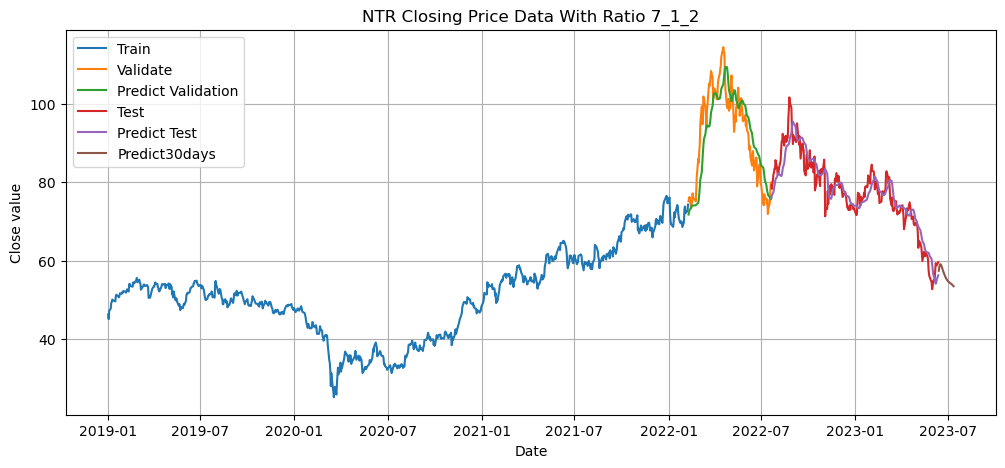

In [18]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data)

# Validation set
plt.plot(df[train_size : train_size + val_size].index, val_data)

# Predict in validation set
plt.plot(df[train_size : train_size + val_size].index, y_pred_val)

# Test set
plt.plot(df[train_size + val_size: ].index, test_data)

# Predict in test set
plt.plot(df[train_size + val_size:].index, y_pred)

# Predict 30 next days
plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Predict Validation', 'Test', 'Predict Test', 'Predict30days'])
plt.grid()
plt.title("NTR Closing Price Data With Ratio 7_1_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RNN_712_NTR.png')
plt.show()